In [1]:
!pip install transformers accelerate --quiet

In [ ]:
from huggingface_hub import login
login("")

In [6]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "mistralai/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [7]:
def generate_text(prompt, model, tokenizer, max_tokens=30):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=max_tokens)
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [8]:
prompt = "My favorite condiment is"
print("Before pruning super weight:")
print(generate_text(prompt, model, tokenizer))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Before pruning super weight:
My favorite condiment is ketchup. I love it on everything. I’m not a fan of mustard, mayo, or relish. I’m not


In [9]:
#zero out the superweight
with torch.no_grad():
    super_weight_tensor = model.model.layers[1].mlp.down_proj.weight
    original = super_weight_tensor[2070, 7310].item()
    print(f"Original super weight value: {original:.6f}")
    super_weight_tensor[2070, 7310] = 0.0
    print("Super weight zeroed.")

Original super weight value: -0.273438
Super weight zeroed.


In [10]:
print("After pruning super weight:")
print(generate_text(prompt, model, tokenizer))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


After pruning super weight:
My favorite condiment is not.
GroupLayout in.........................


In [11]:
import torch.nn as nn

activation_stats = []

def record_activations(module, input, output):
    inp_max = input[0].abs().max().item()
    out_max = output.abs().max().item()
    activation_stats.append((inp_max, out_max))

# Attach hooks to down_proj of every MLP layer
hooks = []
for i, layer in enumerate(model.model.layers):
    hooks.append(layer.mlp.down_proj.register_forward_hook(record_activations))

In [12]:
prompt = "The meaning of life is"
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

with torch.no_grad():
    _ = model(**inputs)

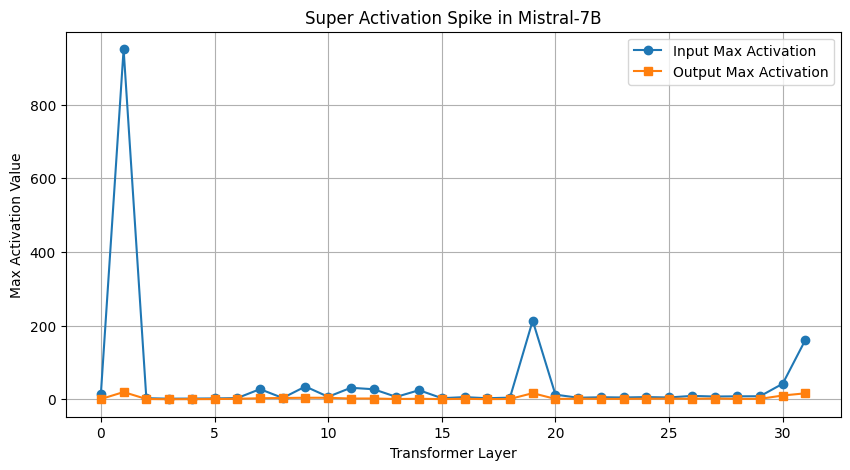

In [13]:
import matplotlib.pyplot as plt

inp_activations = [x[0] for x in activation_stats]
out_activations = [x[1] for x in activation_stats]
layers = list(range(len(inp_activations)))

plt.figure(figsize=(10, 5))
plt.plot(layers, inp_activations, label="Input Max Activation", marker='o')
plt.plot(layers, out_activations, label="Output Max Activation", marker='s')
plt.title("Super Activation Spike in Mistral-7B")
plt.xlabel("Transformer Layer")
plt.ylabel("Max Activation Value")
plt.legend()
plt.grid(True)
plt.show()
